This code is written by Fengyu Zhong, aiming to build a number of functions and tools that can replicate the data analysis work
done previously by excel.

The sample codes are labeled deliberately by e.g a1, a2, c1 etc. It is aiming to provide a guide to the order of function usage. The order are also implied in return and input variable names.

The dataframes which are the same but achieved by different function calls (i.e those obtained directly by calling large functions and those obtained by calling small functions step by step) will be named the same in example codes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns

#let python display all columns on output.
pd.set_option('display.max_columns', None)

File_Assember( ):
Read one or multiple concatenated files into a dataframe.

Input: file path.

Output: A pandas dataframe.

In [2]:
#set the file path, users can change to their own paths
path = r'C:\Users\Eric Zhong\Documents\2.INTERNSHIP\RESEARCH\iFiles_for_Leo'

#The function passes in the file path and file_no_, which means the number of file in order. 
#For example, we want to read the 5th txt file only: File_Assembler(path_, 5, 5)
#If we want to read files 1 - 7: File_Assembler(path_, 1, 7)
#in total 58 txt files for now

def File_Assembler(path_, file_lwr_, file_upper_):
    all_files = glob.glob(path_ + "/*.txt")
    count = 0
    #create an empty array, and use a for loop to append files to the array.
    li = []
    for filename in all_files:
        count = count + 1
        if count >= file_lwr_ and count <= file_upper_:
            x = pd.read_csv(filename, index_col=None, header=0, sep = '\t')
            li.append(x)
    Assembled_File = pd.concat(li, axis=0, ignore_index=True)
    return Assembled_File

In [3]:
#df = File_Assembler(path, 17, 17)

R:\ProgramFiles\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
#a = df

File_Loader( )
Used when the user only wants to load one file as an alternative

INPUT:
    File path
    The number of file

OUTPUT:
    Dataframe containing the data


In [3]:
#Since now the scenario has changed, File_assembler is no longer needed at most times. A File_loader is written below
#in order to load single files more efficiently. User passes in the path and also the order number of file.
def File_Loader(path_, file_no_):
    all_files = glob.glob(path_ + "/*.txt")
    count = 0
    for filename in all_files:
        count = count + 1
        if count == file_no_:
            file_ = pd.read_csv(filename, index_col=None, header=0, sep = '\t')
    return file_

NONOX_data: A BIG function that reproduces the excel sheet's NONOX data, leaving only PMAX
Input
    Data from File_Assembler or File_Loader
    Time_alignment_constant, which is found to be 265 CAD in excel sheet 255
    TDC, EVO, EVC: 600, 128, 382 in excel sheet.
    NOoffset: The magical -390 constant when calculating NO average
    Engine cycle period: 720 for ours
Output
    Dataframe that contains all NONOX data in excel sheet.

In [5]:
def NONOX_data(Assembled_Data, time_alignment_constant_, TDC, EVO, EVC, NOoffset, Engine_Cycle_Period_ = 720):
#-------------------------------------------------tidy up the original dataframe-----------------------------------------
    #replace variable names for convenience
    a = Assembled_Data
    p = Engine_Cycle_Period_
    # drop all unneccessary columns, and the units row.
    a = a[['Crank Angle', 'NO', 'NOx']].drop([0])
    # change data types from strings to floats
    a = a.astype('float64')
    # drop all rows with 0 values
    a = a[a.NO != 0.0000]
    #reset the index and drop original index column
    a = a.reset_index().drop(['index'], axis=1)
    #set crank angle as the index
    a = a.set_index('Crank Angle')
    
#---------------------------------------------Generate basic data from existing data----------------------------------------
    # Create two columns for NONOX in ppm
    a['NO_ppm'] = a['NO'] * 200
    a['NOx_ppm'] = a['NOx'] * 200
    # Create NOx time aligned by shifting Nox_ppm values up by time constant amount 
    a['NOx_ppm_ta'] = a['NOx_ppm'].shift(-time_alignment_constant_)
    # Create NO2 column
    a['NO2'] = a['NOx_ppm_ta'] - a['NO_ppm']
    # Create NO2/NOx column
    a['NO2/NOx'] = a['NO2'] / a['NOx_ppm_ta']

#---------------------------------------------Generate Average NO, NOx since CAD 75000--------------------------------------
    # Fill the columns since CAD 75000
    x = 0
    while (x*p - NOoffset + TDC + EVC < a.shape[0]):
        a.loc[75000+x, 'NO_Avg'] = a['NO_ppm'].loc[75000 + x*p - NOoffset + TDC + EVO : 75000 + x*p - NOoffset + TDC + EVC].mean()
        a.loc[75000+x, 'NOx_Avg'] = a['NOx_ppm'].loc[75000 + x*p + TDC + EVO : 75000 + x*p + TDC + EVC].mean()
        x = x + 1
#--------------------------------------------NO2 avg and NO2/No avg--------------------------------------------------------
    a['NO2_Avg'] = a['NOx_Avg'] - a['NO_Avg']
    a['NO2/NO_Avg'] = a['NO2_Avg'] / a['NOx_Avg']

    return a

In [172]:
#b1 = NONOX_data(a, time_alignment_constant_=265,TDC=600,EVO=128,EVC=382,NOoffset=390)

In [ ]:
#######################################Break the above function into small ones ############################################

Filter_NONOX( ):
    This function filters the original dataframe to contain only NO, NOx (V) indexed by crank angle

In [6]:
def Filter_NONOX(Assembled_Data):
#-------------------------------------------------tidy up the original dataframe-----------------------------------------
    #replace variable names for convenience
    a = Assembled_Data
    # drop all unneccessary columns, and the units row.
    a = a[['Crank Angle', 'NO', 'NOx']].drop([0])
    # change data types from strings to floats
    a = a.astype('float64')
    # drop all rows with 0 values
    a = a[a.NO != 0.0000]
    #reset the index and drop original index column
    a = a.reset_index().drop(['index'], axis=1)
    #set crank angle as the index
    a = a.set_index('Crank Angle')
    return a

In [ ]:
#b1 = Filter_NONOX(a)

TimeAlignmentNO2( )
With the user supplying NONOX filtered dataframe:
    This function adds columns for:
        NO NOX in ppm
        NOX timealigned
        NO2 and NO2/NOX
    

In [138]:
def TimeAlignmentNO2(Filter_NONOX_Output_, time_alignment_constant_):
#-------------------------------------------------tidy up the original dataframe-----------------------------------------
    #replace variable names for convenience
    a = Filter_NONOX_Output_
    
#---------------------------------------------Generate basic data from existing data----------------------------------------
    # Create two columns for NONOX in ppm
    a['NO_ppm'] = a['NO'] * 200
    a['NOx_ppm'] = a['NOx'] * 200
    # Create NOx time aligned by shifting Nox_ppm values up by time constant amount 
    a['NOx_ppm_ta'] = a['NOx_ppm'].shift(-time_alignment_constant_)
    # Create NO2 column
    a['NO2'] = a['NOx_ppm_ta'] - a['NO_ppm']
    # Create NO2/NOx column
    a['NO2/NOx'] = a['NO2'] / a['NOx_ppm_ta']
    return a

In [ ]:
#c1 = TimeAlignmentNO2(b1, time_alignment_constant_ = 265)

NONOX_Cyclic_Avg( ):
    A funtion that calculates the average of NO NOx within sampling window from CAD 75000 onwards, and generate NO2 NO2/NOX average.

INPUT:
    Output of TimeAlignmentNO2
    TDC EVO EVC
    NOoffset: the magical 390 in excel sheet 255
    Engine period of 720
OUTPUT: 
    After this function, one should be able to obtain a dataframe containing all NONOX data.

In [159]:
def NONOX_Cyclic_Avg(TimeAlignmentNO2_Output_, TDC, EVO, EVC, NOoffset):
    #simplify variable name for convenience
    Engine_Cycle_Period_=720
    a = TimeAlignmentNO2_Output_
    p = Engine_Cycle_Period_
    x = 0
    while (x*p - NOoffset + TDC + EVC < a.shape[0]):
        a.loc[75000+x, 'NO_Avg'] = a['NO_ppm'].loc[75000 + x*p - NOoffset + TDC + EVO : 75000 + x*p - NOoffset + TDC + EVC].mean()
        a.loc[75000+x, 'NOx_Avg'] = a['NOx_ppm'].loc[75000 + x*p + TDC + EVO : 75000 + x*p + TDC + EVC].mean()
        x = x + 1
        
    a['NO2_Avg'] = a['NOx_Avg'] - a['NO_Avg']
    a['NO2/NO_Avg'] = a['NO2_Avg'] / a['NOx_Avg']

    return a

In [ ]:
#d1 = NONOX_Cyclic_Avg(c1, TDC=600, EVO=128,EVC=382,NOoffset=390)

NO_NOx_plotter( )
Plots NO NOx data against crank angle.

Input:
    The NONOx filtered dataframe.
    Start and end CAD he wishes to plot, by default 0 - 4319999.
    Whether to plot NO, NOx or both
    y lower and upper limit, 0 and 9 by default, which is the range of the entire dataframe.

Output: NO NOX plot.

In [161]:
def NONOX_v_plotter(Filtered_data_, NOoffset_, Start_Crank_Angle_ = -360, End_Crank_Angle_ = 431640, plot_NO = True, plot_NOx = True, y_lower_limit_ = 0, y_upper_limit_ = 3):
    axes = plt.gca()
    a = Filtered_data_
    c = NOoffset_
    sca = Start_Crank_Angle_
    eca = End_Crank_Angle_
    yll = y_lower_limit_
    yul = y_upper_limit_
    #FROM EXCEL SHEET 255, CRANK ANGLE STARTS AT 75390, NO STARTS AT 75000
    a['NOshifted'] = a['NO'].shift(c)
    if plot_NO == True and plot_NOx == True:
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NOshifted', label = 'NO', ylim = (yll , yul), ax=axes)
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NOx', ylim = (yll , yul), ax=axes)
    elif plot_NO == True and plot_NOx == False:
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NOshifted', label = 'NO', ylim = (yll , yul), ax=axes)
    else:
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NOx', ylim = (yll , yul), ax=axes)
    axes.set(xlabel="Crank Angle", ylabel="V")
    a.drop(columns=['NOshifted'])
    plt.show()
#as an example, we want to plot from "engine", from 205000 CAD to 215000 degree, the variation of NOx only:
#NO_NOx_plotter(engine, 205000, 215000, False, True)
#or, as False = 0, and True = 1:
#NO_NOx_plotter(engine, 205000, 215000, 0, 1)

In [163]:
#NONOX_in_V = NONOX_v_plotter(d1, NOoffset_=390, Start_Crank_Angle_=75000,End_Crank_Angle_=77000,plot_NO=True,plot_NOx=True)

In [164]:
def NONOX_ppm_plotter(Filtered_data_, NOoffset_, Start_Crank_Angle_ = -360, End_Crank_Angle_ = 431640, plot_NO = True, plot_NOx = True, plot_ratio = True, y_lower_limit_ = 0, y_upper_limit_ = 600, ylwrlmt_right = -0.5, yuprlmt_right = 0.5):
    axes = plt.gca()
    a = Filtered_data_
    c = NOoffset_
    sca = Start_Crank_Angle_
    eca = End_Crank_Angle_
    yll = y_lower_limit_
    yul = y_upper_limit_
    yllr = ylwrlmt_right
    yulr = yuprlmt_right
    
    #shifting the columns to plot as the excel sheets!
    a['NOshifted_ppm'] = a['NO_ppm'].shift(-c)
    a['NO2/NOxshifted'] = a['NO2/NOx'].shift(-c)
    if plot_NO == True and plot_NOx == True and plot_ratio == True:
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NOshifted_ppm', label = 'NO_ppm', ylim = (yll , yul), ax=axes)
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NOx_ppm', ylim = (yll , yul), ax=axes)
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NO2/NOxshifted',secondary_y=True, label = 'NO2/NOx', ax=axes)
        axes.right_ax.set_ylim(yllr,yulr)
    elif plot_NO == True and plot_NOx == True and plot_ratio == False:
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NOshifted_ppm', label = 'NO_ppm', ylim = (yll , yul), ax=axes)
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NOx_ppm', ylim = (yll , yul), ax=axes)
    elif plot_NO == True and plot_NOx == False and plot_ratio == True:
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NOshifted_ppm', label = 'NO_ppm', ylim = (yll , yul), ax=axes)
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NO2/NOxshifted',secondary_y=True, label = 'NO2/NOx', ax=axes)
        axes.right_ax.set_ylim(yllr,yulr)
    elif plot_NO == True and plot_NOx == False and plot_ratio == False:
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NOshifted_ppm', label = 'NO_ppm', ylim = (yll , yul), ax=axes)
    elif plot_NO == False and plot_NOx == True and plot_ratio == True:
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NOx_ppm', ylim = (yll , yul), ax=axes)
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NO2/NOxshifted',secondary_y=True, label = 'NO2/NOx', ax=axes)
        axes.right_ax.set_ylim(yllr,yulr)
    elif plot_NO == False and plot_NOx == True and plot_ratio == False:
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NOx_ppm', ylim = (yll , yul), ax=axes)
    elif plot_NO == False and plot_NOx == False and plot_ratio == True:
        a.reset_index().reset_index().iloc[sca + 360 : eca + 360].plot(kind='line', x='index', y='NO2/NOxshifted',secondary_y=True, label = 'NO2/NOx', ax=axes)
        axes.right_ax.set_ylim(yllr,yulr)
    axes.set(xlabel="Crank Angle", ylabel="ppm")
    #a = a.drop(columns=['NOshifted_ppm', 'NO2/NOxshifted'])
    plt.show()
    return a
#as an example, we want to plot from "engine", from 205000 CAD to 215000 degree, the variation of NOx only:
#NO_NOx_plotter(engine, 205000, 215000, False, True)
#or, as False = 0, and True = 1:
#NO_NOx_plotter(engine, 205000, 215000, 0, 1)

In [166]:
#NONOX_in_ppm = NONOX_ppm_plotter(d1,NOoffset_=390,Start_Crank_Angle_=77000,End_Crank_Angle_=80000,plot_NO=True,plot_NOx=False,plot_ratio=True)

Filter_Shifted( )
    The function aims to clean up and get rid of the extra shifted columns generated from the plots functions
    as I did not manage to find a way to stop the functions generating the extra columns
INPUT:
    The dataframe after plots, two boolean variables to indicate whether the user has used the two plot functions
    by default, the user is assumed to NOT have plotted, hence the function wont do anything

OUTPUT:
    Cleaned dataframe

In [167]:
def Filter_Shifted(Plots_Output, NO_v_plotted = False, NO_ratio_ppm_plotted = False):
    a = Plots_Output
    if NO_v_plotted == True and NO_ratio_ppm_plotted == True:
        a = a.drop(columns = ['NOshifted', 'NOshifted_ppm', 'NO2/NOxshifted'])
    elif NO_v_plotted == True and NO_ratio_ppm_plotted == False:
        a = a.drop(columns = ['NOshifted'])
    elif NO_v_plotted == False and NO_ratio_ppm_plotted == True:
        a = a.drop(columns = ['NOshifted_ppm', 'NO2/NOxshifted'])

    return a

In [168]:
#e1 = Filter_Shifted(d1, NO_v_plotted=True, NO_ratio_ppm_plotted= True)

Time( )
    This function calculates the average time taken after each crank angle, and allows user to input the starting crank angle.

In [169]:
def Time(dataframe, Start_Crank_Angle):
    a = dataframe
    s = Start_Crank_Angle
    Avg_Time = []
    for value in a.index:
        Avg_Time.append((360 + value)*0.04)
    a['Avg_Time'] = Avg_Time
    a['Avg_Time'] = a['Avg_Time'].shift(s + 360)
    return a

In [ ]:
#f1 = Time(e1,75000)

In [ ]:
############################################## PRESSURE FUNCTIONS FROM NOW ON##############################################

PMAX_DATA( )
    This a big function that takes in the raw data output from File_Assembler(). It returns a dataframe that contains PMAX
    data indexed by the starting crank angle supplied by user, same as the work done in excel.
    
    Due to the length of the function, no comments are added.
    
    The function will be broken down into smaller parts later on, and the explanations and comments will be attached there.

In [191]:
def PMAX_DATA(Assembled_Data, Start_Crank_Angle_):
    p = Assembled_Data
    p = p[['Crank Angle', 'PCYL1']].drop([0]).astype('float64').set_index(['Crank Angle'])
    
    rand_sampling_index = np.random.randint(1,10)
    sample_index = pd.DataFrame([1,2,3,4,5,6,7,8,9,10]).sample(frac = 1)

    sample_n_360 = p.loc[-360].sample(n = 1)
    
    n1 = int((p.loc[-359:-1].count())/10)
    randomizercolumn1 = pd.concat([sample_index] * n1)
    randomizercolumn1.index = p.loc[-359:-1].index
    t1 = pd.concat([randomizercolumn1, p.loc[-359:-1]], axis = 1)
    t1 = t1[t1[0] == rand_sampling_index]
    first_part = t1.drop([0], axis = 1)
    
    sample_0 = p.loc[0].sample(n = 1)
        
    n2 = int((p.loc[1:431639].count())/10)
    randomizercolumn2 = pd.concat([sample_index] * n2)
    randomizercolumn2.index = p.loc[1:431639].index
    t2 = pd.concat([randomizercolumn2, p.loc[1:431639]], axis = 1)
    t2 = t2[t2[0] == rand_sampling_index]
    second_part = t2.drop([0], axis = 1)

    sample_431640 = p.loc[431640].sample(n = 1)
    
    P_sampled = pd.concat([sample_n_360, first_part, sample_0, second_part, sample_431640])
    
    Period_ = 720
    SCA = Start_Crank_Angle_
    PMAX_ = pd.DataFrame([], columns = ['PMAX', 'Crank Angle']).set_index('Crank Angle')
    x = 0

    while ((SCA+Period_*(x+1)-1) < P_sampled.shape[0]):
        PMAX_.loc[SCA+x] = float(P_sampled.loc[SCA+Period_*x:SCA+Period_*(x+1)-1].max())
        x = x + 1
        
    return PMAX_

In [ ]:
#d2 = PMAX_DATA(a, 75000)

Filter_PCYL1( ):

Input:
    Data from File_Assembler or File_Loader.

Output: 
    Dataframe that contains only Crank Angle, PCYL1.

In [189]:
def Filter_PCYL1(Assembled_Data):
    P_Dataframe_ = Assembled_Data
    # drop all unneccessary columns, and the units row.
    P_Dataframe_ = P_Dataframe_[['Crank Angle', 'PCYL1']].drop([0])
    # change data types from strings to floats
    P_Dataframe_ = P_Dataframe_.astype('float64')
    #reset the index and drop original index column
    P_Dataframe_ = P_Dataframe_.set_index(['Crank Angle'])
    #Assembled_Data_filtered = Assembled_Data_filtered.reset_index().drop(['index'], axis=1)
    #Make Crank Angle start at 0 instead of -360
    #Assembled_Data_filtered['Crank Angle'] = Assembled_Data_filtered['Crank Angle'] + 360

    return P_Dataframe_

In [ ]:
#b2 = Filter_PCYL1(a)

Psample( ) returns a dataframe that contains sampled PCYL1 data.

The relatively quick sampling is achieved by appending a column of integer 1 to 10 in random order, and sample a specific
row with a random number generated at start of the function.

With CAD -360, 0, 431640 containing less than 10 rows, we have to treat them separately, hence the entire function
contains 5 parts. In the end, we concatenate them all together.

In [188]:
 def Psample(P_Dataframe_):
    p = P_Dataframe_
    
    #generate a random integer for sampling
    rand_sampling_index = np.random.randint(1,10)
    #create index 1:10
    sample_index = pd.DataFrame([1,2,3,4,5,6,7,8,9,10])
    #Randomize the sample_index
    sample_index = sample_index.sample(frac = 1)
    
    
    #randomly sample a data for -ve 360
    sample_n_360 = P_Dataframe_.loc[-360].sample(n = 1)

    #deal with all CADs inbetween -360 and 0
    #dupilicate random index by [(rows -359:-1 )/10 = n1] number of times
    n1 = int((p.loc[-359:-1].count())/10)
    #concatenate all 1-10 repeats for n1 times in a column
    randomizercolumn1 = pd.concat([sample_index] * n1)
    #copy the index of input DataFrame, which is 'Crank Angle', to the newly created randomizer column
    randomizercolumn1.index = p.loc[-359:-1].index
    #Now that both the dataframe and randomizer column are indexed by 'Crank Angle', we concatenate them side by side
    t1 = pd.concat([randomizercolumn1, p.loc[-359:-1]], axis = 1)
    #Use the random number generated at first to sample. The randomizer column has column name as '0'
    t1 = t1[t1[0] == rand_sampling_index]
    #Now drop the randomizer column with column name '0'.
    first_part = t1.drop([0], axis = 1)
    
    #Deal with 0
    sample_0 = p.loc[0].sample(n = 1)
        
    #all CADS inbetween 0 and 431640 same before.
    n2 = int((p.loc[1:431639].count())/10)
    randomizercolumn2 = pd.concat([sample_index] * n2)
    randomizercolumn2.index = p.loc[1:431639].index
    t2 = pd.concat([randomizercolumn2, p.loc[1:431639]], axis = 1)
    t2 = t2[t2[0] == rand_sampling_index]
    second_part = t2.drop([0], axis = 1)

    #Deal with 431640
    sample_431640 = p.loc[431640].sample(n = 1)
    
    #concatenate all 5 parts together vertically.
    P_sampled = pd.concat([sample_n_360, first_part, sample_0, second_part, sample_431640])
    
    
    return P_sampled

In [ ]:
#c2 = Psample(b2)

Psample_MAXMAX( )
    This is a test function which instead of sampling, take the maximum PCLY1 per CAD.

In [134]:
def Psample_MAXMAX(P_Dataframe_):
    p = P_Dataframe_
    P_sampled = P_Dataframe_.groupby(p.index).max()
    return P_sampled

In [ ]:
#c2 = Psample_MAXMAX(b2)

PMAX( ):
Extracts cyclic maximum PCYL1.

INPUT:
    PCYL1 filtered dataframe
    Offset of engine cycle (how much CAD does the engine go through before the first recorded cycle)
    Engine cycle period
OUTPUT:
    A dataframe that contains maximum PCYL1 for every engine cycle

In [8]:
def PMAX(P_sampled, Start_Crank_Angle_ = -360):
    Period_ = 720
    SCA = Start_Crank_Angle_
    PMAX_ = pd.DataFrame([], columns = ['PMAX', 'Crank Angle']).set_index('Crank Angle')
    x = 0

    while ((SCA+Period_*(x+1)-1) < P_sampled.shape[0]):
        #Find the max pressure value for every 720 degree cycle, append to the PMAX_ dataframe.
        PMAX_.loc[SCA+x] = float(P_sampled.loc[SCA+Period_*x:SCA+Period_*(x+1)-1].max())
        #increment x
        x = x + 1
        
    return PMAX_
#The output dataframe should have its index as the number of cycles.

In [ ]:
#d2 = PMAX(c2, Start_Crank_Angle_=75000)

Merge_PMAX_NONOX()
    Merge the two input NONOX and Pmax dataframe together.

In [173]:
def Merge_PMAX_NONOX(NONOX_Dataframe_, Pmax_Dataframe_):
    df1 = NONOX_Dataframe_
    df2 = Pmax_Dataframe_
    df3 = pd.concat([df1, df2], axis = 1)
    return df3

In [ ]:
#Merged = Merge_PMAX_NONOX(f1, d2)

Correlation_NOavg_PMAX() makes a scatter plot of NONOX and also returns R value, the default limits are set according excel files, for reasons which i dont know of.


In [184]:
def Correlation_NOavg_PMAX_plot(Merged_Pmax_NONOX_dataframe, PMAXlower_CAD = 75000, PMAXupper_CAD = 75140, NONOXlower_CAD = 75001, NONOXupper_CAD = 75141, plotNO = True, plotNOX = False):
    df3 = Merged_Pmax_NONOX_dataframe
    pl = PMAXlower_CAD
    pu = PMAXupper_CAD
    nl = NONOXlower_CAD
    nu = NONOXupper_CAD
    #Regression plots with 
    if plotNO == True:
        sns.regplot(y=df3['PMAX'].loc[pl:pu],x=df3['NO_Avg'].loc[nl:nu],data=x,fit_reg=True)
        Rsquared = df3['PMAX'].corr(df3['NO_Avg'])
    elif plotNOX == True:
        sns.regplot(y=df3['PMAX'].loc[pl:pu],x=df3['NOx_Avg'].loc[nl:nu],data=x,fit_reg=True)
        Rsquared = df3['PMAX'].corr(df3['NOx_Avg'])
        print(Rsquared)
    return Rsquared
    

In [185]:
#Correlation_NOavg_PMAX_plot(Merged, PMAXlower_CAD=75000,PMAXupper_CAD=75140,NONOXlower_CAD=75001,NONOXupper_CAD=75141,plotNO=True,plotNOX=False)

NO2_NOx_ratio_vs_avgtime()
    plots a scatter plot of the ratio against avg time.

In [149]:
def NO2_NOx_ratio_vs_avgtime(DataframeWithTime_, Start_Crank_Angle_, End_Crank_Angle_):
    df = DataframeWithTime_
    SCA = Start_Crank_Angle_
    ECA = End_Crank_Angle_
    df1 = df[SCA:ECA]
    df1.plot.scatter(x='Avg_Time',y='NO2/NO_Avg', c='DarkBlue')

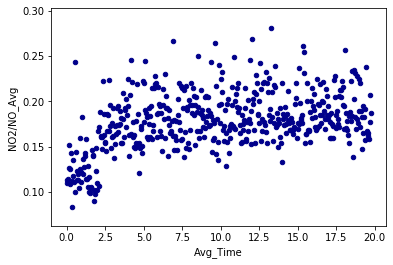

In [154]:
#NO2_NOx_ratio_vs_avgtime(f1, 75000, 431639)

In [119]:
c = Time(c, 75000)

In [14]:
testpath = r'C:\Users\Eric Zhong\Documents\2.INTERNSHIP\RESEARCH'

In [34]:
x = pd.read_csv(r'C:\Users\Eric Zhong\Documents\2.INTERNSHIP\RESEARCH\test.txt', index_col=None, header=0, sep = '\t')

In [38]:
x = x.astype('float64')